In [ ]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
from google.colab import files
print("Please select 'arrhythmia.data'\n")
uploaded = files.upload()

Please select 'arrhythmia.data'



Saving arrhythmia.data to arrhythmia.data


In [ ]:
#Create feature list
mylist1 = ['Q wave', 'R wave', 'S wave', "R' wave", "S' wave",
         'Number of intrinsic deflections', 'Existence of ragged R wave',
         'Existence of diphasic derivation of R wave', 'Existence of ragged P wave',
         'Existence of diphasic derivation of P wave', 'Existence of ragged T wave',
         'Existence of diphasic derivation of T wave']
mylist2 = ['JJ wave', 'Q wave', 'R wave', 'S wave', "R' wave", "S' wave",
         'P wave', 'T wave', 'QRSA', 'QRSTA']
listofchannels = ['DI', 'DII', 'DIII', 'AVR', 'AVL', 'AVF', ' V1', 'V2', 'V3',
                  'V4', 'V5', 'V6']

label_list = ['Age', 'Sex', 'Height', 'Weight', 'QRS interval', 'PR interval',
              'QT interval', 'T interval', 'P interval', 'QRS', 'T', 'P', 'QRST',
              'J', 'Heart rate'] +\
             [s + ' avg width ' + t for t in listofchannels for s in mylist1] +\
             [s + ' ampl ' + t for t in listofchannels for s in mylist2] +\
             ['Class']

In [ ]:
#Read database
df = pd.read_csv("arrhythmia.data", na_values = '?', header = None, names = label_list)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, Age to Class
dtypes: float64(125), int64(155)
memory usage: 988.9 KB


In [ ]:
#MISSING VALUES
too_many_list = []
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    if pct_missing != 0:
        print('{} - {} missing values - {}%'.format(col, df[col].isnull().sum(), round(pct_missing*100, ndigits=2)))
        if pct_missing >= 0.6:
            too_many_list.append(col)
print('Too many missing values', too_many_list)

T - 8 missing values - 1.77%
P - 22 missing values - 4.87%
QRST - 1 missing values - 0.22%
J - 376 missing values - 83.19%
Heart rate - 1 missing values - 0.22%
Too many missing values ['J']


In [ ]:
#remove those with too many missing values
df = df.drop(too_many_list,axis=1)

In [ ]:
missingvalues_list = []
for col in df.columns:
    pct_missing = np.mean(df[col].isna())
    if pct_missing != 0:
        print('{} - {} missing values - {}%'.format(col, df[col].isnull().sum(), round(pct_missing*100, ndigits=2)))
        print('dtype: {}'.format(df[col].dtypes))
        missingvalues_list.append(col)

T - 8 missing values - 1.77%
dtype: float64
P - 22 missing values - 4.87%
dtype: float64
QRST - 1 missing values - 0.22%
dtype: float64
Heart rate - 1 missing values - 0.22%
dtype: float64


In [ ]:
df_mv = df[missingvalues_list]
df_mv_labels = df_mv.columns
df_incomplete = df.drop(missingvalues_list, axis = 1)

simp_imp=SimpleImputer(strategy='mean')
df_mv = simp_imp.fit_transform(df_mv)
df_mv = pd.DataFrame(df_mv, columns = df_mv_labels)
df = pd.concat([df_incomplete, df_mv], axis = 1)
print("NaN values in dataframe (after imputing): ", df.isna().sum().sum())

NaN values in dataframe (after imputing):  0


In [ ]:
#OUTLIERS
#standard deviation of numerical features
no_var_list = []
for col in df.columns:
    if df[col].std() == 0.0 or df[col].std() == 0:
        no_var_list.append(col)
        print(str(col), df[col].std())

S' wave avg width DI 0.0
S' wave avg width AVL 0.0
Existence of ragged R wave avg width AVL 0.0
Existence of ragged P wave avg width AVF 0.0
Existence of ragged P wave avg width V4 0.0
Existence of diphasic derivation of P wave avg width V4 0.0
S' wave avg width V5 0.0
Existence of ragged R wave avg width V5 0.0
Existence of ragged P wave avg width V5 0.0
Existence of ragged T wave avg width V5 0.0
S' wave avg width V6 0.0
Existence of diphasic derivation of P wave avg width V6 0.0
Existence of ragged T wave avg width V6 0.0
S' wave ampl DI 0.0
S' wave ampl AVL 0.0
S' wave ampl V5 0.0
S' wave ampl V6 0.0


In [ ]:
#remove those with zero variance
df = df.drop(no_var_list,axis=1)

In [ ]:
#FEATURE IMPORTANCE
print('Number of features: ', df.shape[1])
cor_df = df.corr(method = "pearson").round(2)
thres=0.95
corr_matrix=cor_df.values
rows,cols=np.where(np.abs(corr_matrix)>thres)
index=np.where(rows!=cols)
rows_to_drop=rows[index][:round(len(rows[index])/2)]
cols_to_drop=cols[index][:round(len(rows[index])/2)]

print('Columns with |correlation|>' + str(thres) + ':\n')
print(rows_to_drop)

cor_95 = cor_df.iloc[rows_to_drop, cols_to_drop]
print(cor_95)

# plt.figure(figsize=(12,10))
# sns.heatmap(cor_95, annot=True, cmap=plt.cm.Reds)
# plt.show()

Number of features:  262
Columns with |correlation|>0.95:

[ 49  71  82 106 118 135]
                       S' wave ampl AVR  S' wave ampl AVF  S' wave ampl  V1  \
S' wave avg width AVR              -1.0              0.00              0.00   
S' wave avg width AVF               0.0             -0.97              0.00   
S' wave avg width  V1               0.0              0.01             -0.96   
S' wave avg width V3                0.0              0.00              0.00   
S' wave avg width V4                0.0              0.00              0.00   
R' wave avg width V6                0.0              0.01              0.01   

                       R' wave ampl V3  S' wave ampl V4  R' wave ampl V6  
S' wave avg width AVR            -0.00             0.00            -0.00  
S' wave avg width AVF            -0.01             0.00            -0.01  
S' wave avg width  V1            -0.01             0.00            -0.01  
S' wave avg width V3              0.97             0.00      

In [ ]:
df = df.drop(columns = df.columns[rows_to_drop])
print('Number of features: ', df.shape[1])

Number of features:  256


In [ ]:
cor_df = df.corr(method = "pearson").round(2)
thres=0.65
corr_matrix=cor_df.values
rows,cols=np.where(np.abs(corr_matrix)>thres)
index=np.where(rows!=cols)
rows_to_drop=rows[index][:round(len(rows[index])/2)]
cols_to_drop=cols[index][:round(len(rows[index])/2)]

print('Columns with |correlation|>' + str(thres) + ':\n')
print(rows_to_drop)

df = df.drop(columns = df.columns[rows_to_drop])
print('Number of features: ', df.shape[1])

Columns with |correlation|>0.65:

[  2   2   2   5   8   9   9   9   9   9   9   9  10  11  12  13  15  21
  22  22  23  23  24  25  29  31  32  33  34  34  35  35  37  44  45  45
  45  46  46  47  47  47  48  49  52  52  54  55  56  57  57  58  59  63
  65  65  65  65  65  65  66  67  67  67  68  68  68  68  73  76  76  77
  77  78  78  78  79  87  87  88  88  89  90  91  91  99  99 100 100 100
 100 101 102 103 110 110 112 113 117 119 119 119 120 122 123 127 127 128
 128 130 131 133 135 135 135 135 136 137 137 137 138 138 139 141 141 141
 141 141 142 142 142 142 143 143 144 144 144 145 145 146 146 146 146 146
 146 146 146 147 147 147 147 147 148 148 148 148 148 149 150 150 150 151
 151 151 151 152 152 152 152 152 152 152 152 152 153 153 153 153 153 153
 153 153 154 154 155 156 156 156 156 156 156 157 157 158 158 158 159 160
 160 160 161 161 162 162 162 162 162 162 162 162 162 162 162 162 162 162
 163 163 163 163 163 163 163 163 163 163 164 164 164 164 165 165 165 166
 166]
Number of f

In [ ]:
#SCALING
#separate 'Class' feature from scaling
class_feature = df['Class']
df = df.drop(columns = 'Class')
print(df.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df)
df = pd.DataFrame(scaled_df, columns = df.columns)
df = pd.concat([df, class_feature], axis = 1)


Index(['Age', 'Sex', 'Weight', 'QRS interval', 'QT interval', 'T interval',
       'Number of intrinsic deflections avg width DI',
       'Existence of diphasic derivation of R wave avg width DI',
       'Existence of ragged P wave avg width DI',
       'Existence of diphasic derivation of P wave avg width DI',
       ...
       'S wave ampl V6', 'R' wave ampl V6', 'P wave ampl V6', 'T wave ampl V6',
       'QRSA ampl V6', 'QRSTA ampl V6', 'T', 'P', 'QRST', 'Heart rate'],
      dtype='object', length=157)


In [ ]:
print(df['Class'])

0       8
1       6
2      10
3       1
4       7
       ..
447     1
448    10
449     2
450     1
451     1
Name: Class, Length: 452, dtype: int64


In [ ]:
#Save dataframe as pickle file
# df.to_pickle("./arrhytmia.pkl")

Number of instances per class:
 1     245
10     50
2      44
6      25
16     22
3      15
4      15
5      13
9       9
15      5
14      4
7       3
8       2
11      0
12      0
13      0
dtype: int64


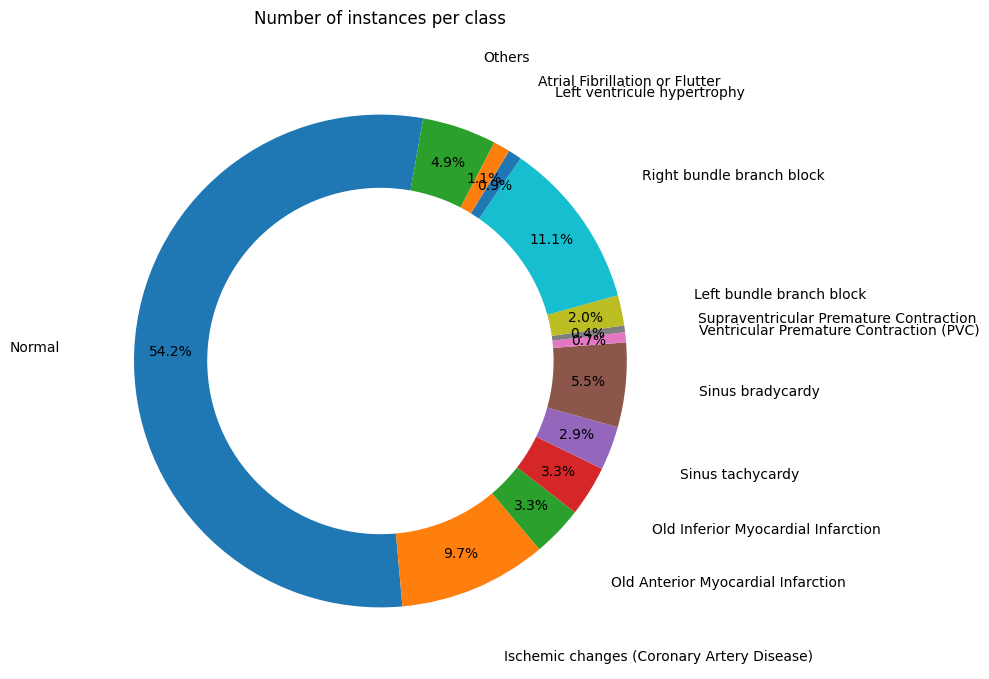

In [ ]:
#Count instances of the 16 classes
per_class = df['Class'].value_counts()
adj=pd.Series(data=[0,0,0], index=['11','12','13'],name='Class')
per_class2=pd.concat([per_class, adj])
print('Number of instances per class:\n', per_class2)

per_class=per_class.sort_index()
plt.figure(figsize=(8,8))
my_circle=plt.Circle((0,0), 0.7, color='white')
label_diseases=['Normal','Ischemic changes (Coronary Artery Disease)',
                'Old Anterior Myocardial Infarction','Old Inferior Myocardial Infarction',
                'Sinus tachycardy','Sinus bradycardy','Ventricular Premature Contraction (PVC)',
                'Supraventricular Premature Contraction','Left bundle branch block',
                'Right bundle branch block','Left ventricule hypertrophy',
                'Atrial Fibrillation or Flutter','Others']
plt.pie(per_class, labels=label_diseases,autopct='%1.1f%%',pctdistance=0.85, labeldistance=1.3, startangle=80)
plt.title("Number of instances per class\n")
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
#TRAIN-TEST SPLIT
df_train,df_test=train_test_split(df, test_size=0.1)
target_train = df_train['Class']
target_train=pd.Series.astype(target_train, dtype= np.int64)
target_test = df_test['Class']
target_test=pd.Series.astype(target_test, dtype= np.int64)
df_train=df_train.drop(labels='Class', axis=1)
df_test=df_test.drop(labels='Class', axis=1)

In [ ]:
#FUNCTIONS
#calculate classification metrics
def metrics(true, pred, prob_pred, classifier):
    accuracy=accuracy_score(true, pred)
    precision=precision_score(true, pred, average='micro')
    recall=recall_score(true, pred, average='micro')
    f1=f1_score(true, pred, average='micro')
    data_metrics=pd.DataFrame(np.array([[accuracy], [precision], [recall], [f1]]).T,
                              columns=['accuracy', 'precision', 'recall', 'f1'])
    data_class=pd.DataFrame([classifier], columns=['classifier'])
    dataframe=pd.concat([data_class,data_metrics], axis=1)
    return dataframe

#calculate classification metrics when predict_proba is not available (ridge classifier)
def metrics2(true, pred, classifier):
    accuracy=accuracy_score(true, pred)
    precision=precision_score(true, pred, average='macro')
    recall=recall_score(true, pred, average='macro')
    f1=f1_score(true, pred, average='macro')
    data_metrics=pd.DataFrame(np.array([[accuracy], [precision], [recall], [f1]]).T,
                              columns=['accuracy', 'precision', 'recall', 'f1'])
    data_class=pd.DataFrame([classifier], columns=['classifier'])
    dataframe=pd.concat([data_class,data_metrics], axis=1)
    return dataframe

#plot confusion matrix and ROC curve
def plots(target_test, pred, classifier):
    conf_display=ConfusionMatrixDisplay.from_predictions(target_test, pred)
    plt.close('all')
    plt.figure()
    plt.title('Confusion matrix')
    plt.plot(conf_display)
    plt.show()

#create metrics_df
metrics_df=pd.DataFrame(columns=['classifier', 'accuracy','precision','recall','f1'])
print(metrics_df)

#update metrics_df
def conc(metrics_df, metr, title):
    if (title in metrics_df['classifier'].unique())==False:
        metrics_df=pd.concat([metrics_df, metr], ignore_index=True)
    else:
        ind=metrics_df.index[metrics_df['classifier'] == title].tolist()
        metr_data=pd.DataFrame(metr, columns=['classifier', 'accuracy','precision','recall','f1'], index=ind)
        metrics_df.update(metr_data)
    return metrics_df

Empty DataFrame
Columns: [classifier, accuracy, precision, recall, f1]
Index: []


In [ ]:
#k-NEAREST NEIGHBORS
parameters = {'n_neighbors':range(3,11,2)}
neigh = KNeighborsClassifier()
clf = GridSearchCV(estimator=neigh, param_grid=parameters, n_jobs=8)
clf.fit(df_train, target_train)
print('Best parameters:',clf.best_params_,'\n Score:',clf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters: {'n_neighbors': 3} 
 Score: 0.583739837398374


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Number of neighbors: 3 

 Classification report:
               precision    recall  f1-score   support

           1       0.48      0.95      0.64        22
           2       0.00      0.00      0.00         5
           3       1.00      1.00      1.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2

    accuracy                           0.48        46
   macro avg       0.15      0.20      0.16        46
weighted avg       0.25      0.48      0.33        46



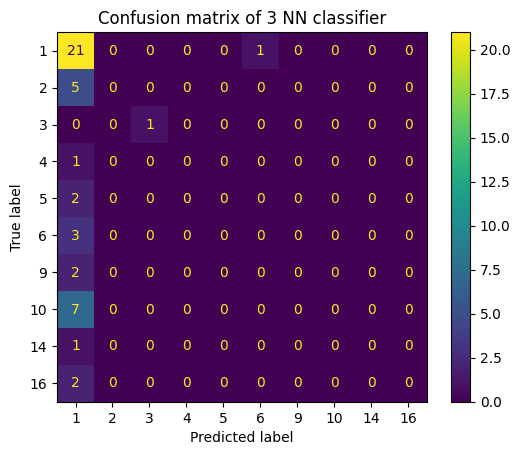

In [ ]:
#k-NEAREST NEIGHBORS II
k=clf.best_params_['n_neighbors']
neigh3 = KNeighborsClassifier(n_neighbors=k)
title=str(k) + ' Nearest Neighbors'
neigh3.fit(df_train,target_train)
pred=neigh3.predict(df_test)
prob_pred=neigh3.predict_proba(df_test)
print('\nNumber of neighbors:',k, '\n\n Classification report:\n',classification_report(target_test, pred, output_dict=False))
# plots(target_test, pred, title)
metr=metrics(target_test, pred, prob_pred, title)
metrics_df=conc(metrics_df, metr, title)

disp=ConfusionMatrixDisplay.from_predictions(target_test, pred)
title='Confusion matrix of ' + str(k) +' NN classifier'
disp.ax_.set_title(title)
plt.show()

In [ ]:
#Support Vector Classifier
parameters = {'kernel' :['linear','poly','rbf', 'sigmoid'], 'degree': list(range(2,6)), 'gamma':['scale', 'auto']}
svc = SVC()
clf = RandomizedSearchCV(estimator=svc, param_distributions=parameters, n_jobs=8)
clf.fit(df_train,target_train)
print('Best parameters for Random Forest:',clf.best_params_,'\n Score:',clf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Random Forest: {'kernel': 'linear', 'gamma': 'auto', 'degree': 4} 
 Score: 0.6919903643480879


In [ ]:
#SVC II
ker=clf.best_params_['kernel']
#bestc=clf.best_params_['C']
deg=clf.best_params_['degree']
gam=clf.best_params_['gamma']
svc = SVC(kernel=ker, degree=deg, gamma=gam, probability=True)
title='SVC (ker=' + str(ker) + '; degree=' + str(deg) + '; gamma=' + str(gam) + ')'
svc.fit(df_train,target_train)
pred=svc.predict(df_test)
prob_pred=svc.predict_proba(df_test)
print('Classification report:\n', classification_report(target_test, pred, output_dict=False))
# plots(target_test, pred, title)
metr=metrics(target_test, pred, prob_pred, title)
metrics_df=conc(metrics_df, metr, title)

Classification report:
               precision    recall  f1-score   support

           1       0.60      0.95      0.74        22
           2       0.33      0.20      0.25         5
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         3
           9       1.00      1.00      1.00         2
          10       1.00      0.43      0.60         7
          14       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2

    accuracy                           0.65        46
   macro avg       0.59      0.51      0.53        46
weighted avg       0.61      0.65      0.59        46



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#GAUSSIAN NAIVE BAYES
gnb = GaussianNB()
title='Gaussian Naive Bayes'
gnb.fit(df_train,target_train)
pred=gnb.predict(df_test)
prob_pred=gnb.predict_proba(df_test)
print('Classification report:\n',classification_report(target_test, pred, output_dict=False))
# plots(target_test, pred, title)
metr=metrics(target_test, pred, prob_pred, title)
metrics_df=conc(metrics_df, metr, title)

Classification report:
               precision    recall  f1-score   support

           1       1.00      0.05      0.09        22
           2       0.00      0.00      0.00         5
           3       1.00      1.00      1.00         1
           4       0.14      1.00      0.25         1
           5       0.00      0.00      0.00         2
           6       0.21      1.00      0.35         3
           9       1.00      0.50      0.67         2
          10       0.25      0.14      0.18         7
          14       0.00      0.00      0.00         1
          16       0.17      0.50      0.25         2

    accuracy                           0.20        46
   macro avg       0.38      0.42      0.28        46
weighted avg       0.61      0.20      0.16        46



In [ ]:
#ridge classifier
parameters = {'alpha':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
clf = RidgeClassifier()
clf = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=8)
clf.fit(df_train, target_train)
print('Best parameters for Ridge Classifier:',clf.best_params_,'\n Score:',clf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Ridge Classifier: {'alpha': 0.8} 
 Score: 0.6722975007527853


In [ ]:
#RIDGE CLASSIFIER II
k=clf.best_params_['alpha']
RidgeClassifier = RidgeClassifier(alpha=k)
title='Ridge Classifier (alpha=' + str(k) + ')'
RidgeClassifier.fit(df_train, target_train)
pred = RidgeClassifier.predict(df_test)
print('Alpha:',k, '\n\n Classification report:\n', classification_report(target_test, pred, output_dict=False))
# plots(target_test, pred, title)
metr=metrics2(target_test, pred, title)
metrics_df=conc(metrics_df, metr, title)

Alpha: 0.8 

 Classification report:
               precision    recall  f1-score   support

           1       0.63      1.00      0.77        22
           2       0.00      0.00      0.00         5
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
           6       0.00      0.00      0.00         3
           9       1.00      1.00      1.00         2
          10       1.00      0.43      0.60         7
          14       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2

    accuracy                           0.65        46
   macro avg       0.56      0.49      0.50        46
weighted avg       0.58      0.65      0.58        46



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
#logistic regression
parameters = {'C' :[100, 10, 1.0, 0.1, 0.01]}
clf = LogisticRegression(max_iter=1000)
clf = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=8)
clf.fit(df_train, target_train)
print('Best parameters for Logistic Regression Classifier:',clf.best_params_,'\n Score:',clf.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Best parameters for Logistic Regression Classifier: {'C': 10} 
 Score: 0.6771454381210479


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#logistic regression II
k=clf.best_params_['C']
logreg = LogisticRegression(C=k, max_iter=1000)
title='Logistic Regression (C=' + str(k) + ')'
logreg.fit(df_train, target_train)
pred = logreg.predict(df_test)
prob_pred=logreg.predict_proba(df_test)
print('C:', k, '\n\nClassification report:\n', classification_report(target_test, pred, output_dict=False))
# plots(target_test, pred, title)
metr=metrics(target_test, pred, prob_pred, title)
metrics_df=conc(metrics_df, metr, title)

C: 10 

Classification report:
               precision    recall  f1-score   support

           1       0.73      1.00      0.85        22
           2       0.60      0.60      0.60         5
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1
           5       1.00      0.50      0.67         2
           6       1.00      0.67      0.80         3
           9       1.00      1.00      1.00         2
          10       1.00      0.43      0.60         7
          14       0.00      0.00      0.00         1
          16       0.00      0.00      0.00         2

    accuracy                           0.76        46
   macro avg       0.73      0.62      0.65        46
weighted avg       0.76      0.76      0.73        46



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

In [ ]:
#TABLE
metrics_df

,classifier,accuracy,precision,recall,f1
0,3 Nearest Neighbors,0.478261,0.478261,0.478261,0.478261
1,SVC (ker=linear; degree=4; gamma=auto),0.652174,0.652174,0.652174,0.652174
2,Gaussian Naive Bayes,0.195652,0.195652,0.195652,0.195652
3,Ridge Classifier (alpha=0.8),0.652174,0.562857,0.492857,0.503860
4,Logistic Regression (C=10),0.760870,0.760870,0.760870,0.760870
